In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle


from unidecode import unidecode
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.optimizers import RMSprop
from keras import regularizers
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import io
def leerStopWords(ruta):
    StopWords = []
    with io.open(ruta,'r', encoding="utf-8") as file:
        for line in file:
            if '#' not in line:
                for token in line.split(','):
                    word = StopWords.append(unidecode(token).rsplit()[0])
                    if word:
                        if len(StopWords) == 0:
                            StopWords.append(word)
                        elif word not in StopWords:
                            StopWords.append(word)
    return StopWords

In [3]:
CustomStopWords = leerStopWords('Stopwords.txt')
non_words = list(punctuation)
non_words.extend(['¿', '¡', 'q', 'd', 'x', 'xq', '...', '..','…','``','`',"'","''"])
stop_words = CustomStopWords + non_words

In [4]:
datos1 = pd.read_csv("Eval01.csv", sep="," ,encoding = 'utf8')#lee el csv eval01
datos1 = datos1.dropna()#quita los valores nulos
datos2 = pd.read_csv("Eval02.csv", sep="," ,encoding = 'utf8')
datos2 = datos2.dropna()
datos3 = pd.read_csv("Eval03.csv", sep="," ,encoding = 'utf8')
datos3 = datos3.dropna()
datos4 = pd.read_csv("Eval04.csv", sep="," ,encoding = 'utf8')
datos4 = datos4.dropna()
datos5 = pd.read_csv("Eval05.csv", sep="," ,encoding = 'utf8')
datos5 = datos5.dropna()
datos1.head()

ActivityCode GraderCode EvaluatedCode       Criterion  NumericalScore  \
0          A01     CA8202        FIS01A       Documento               5   
1          A01     CA8202        FIS01A      Estructura               4   
2          A01     CA8202        FIS01A   Procedimiento               3   
3          A01     CA8202        FIS01A  Funcionamiento               2   
4          A01     CR5742        FIS01A       Documento               5   

                                            Feedback  SentimentPolarity  
0  En los partes solicitadas a evaluar consta con...                  1  
1  la estructura del documento se visualiza corre...                  1  
2  no existen herencias, la relación entre los ca...                 -1  
3  al existir tantos errores en el procedimientos...                 -1  
4  DOCUMENTO CUMPLE CON LOS ESPECIFICADO  EN LA R...                  1

In [5]:
Feedback1 = np.array(datos1["Feedback"].values)
SentimentPolarity1 = np.array(datos1["SentimentPolarity"].values)
print(len(Feedback1))
Feedback2 = np.array(datos2["Feedback"].values)
SentimentPolarity2 = np.array(datos2["SentimentPolarity"].values)
print(len(Feedback2))
Feedback3 = np.array(datos3["Feedback"].values)
SentimentPolarity3 = np.array(datos3["SentimentPolarity"].values)
print(len(Feedback3))
Feedback4 = np.array(datos4["Feedback"].values)
SentimentPolarity4 = np.array(datos4["SentimentPolarity"].values)
print(len(Feedback4))
Feedback5 = np.array(datos5["Feedback"].values)
SentimentPolarity5 = np.array(datos5["SentimentPolarity"].values)
print(len(Feedback5))

Feedback = np.concatenate((Feedback1, Feedback2, Feedback3, Feedback4,Feedback5))
SentimentPolarity = np.concatenate((SentimentPolarity1,  SentimentPolarity2, SentimentPolarity3, SentimentPolarity4,SentimentPolarity5))

912
764
764
764
764


In [6]:
print(len(Feedback))

3968


In [7]:
# Cambio de -1 a 0 en la predicción
SentimentPolarity[SentimentPolarity == -1] = 0

In [8]:
c_train, c_test, p_train, p_test = train_test_split(Feedback, SentimentPolarity,test_size = 0.2, train_size = 0.8 ,random_state=63,shuffle=True)

In [9]:
def preproccess_data(Feedback):
    #Tokenize
    tokens = [word_tokenize(com,"spanish") for com in Feedback]
    #Remove StopWords
    cleanTokens = []
    for words in tokens:
        cleanWords = [unidecode(token.lower()) for token in words if token.lower() not in stop_words]
        cleanTokens.append(cleanWords)
    # Data Returning
    coms = []
    for x in cleanTokens:
        oracion = ""
        for token in x:
            oracion += (" " + token)
        coms.append(oracion)
    return coms

c_train = preproccess_data(c_train)
c_test = preproccess_data(c_test)

In [10]:
from keras.preprocessing.text import Tokenizer as kerasTokenizer

kTokenizer = kerasTokenizer(num_words=10000)
kTokenizer.fit_on_texts(list(c_train)+list(c_test))

t_train = kTokenizer.texts_to_sequences(c_train)
t_test = kTokenizer.texts_to_sequences(c_test)

max_features = len(kTokenizer.word_index) + 1

maxlen = 130
x_train = sequence.pad_sequences(t_train, maxlen=maxlen)
x_test = sequence.pad_sequences(t_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('X:', max_features)

x_train shape: (3174, 130)
x_test shape: (794, 130)
X: 2618


In [11]:
embedding_dims =100
lstm_out = 16
model = Sequential()
e = Embedding(max_features, embedding_dims, input_length=maxlen, trainable=False) 
model.add(e)
model.add(LSTM(lstm_out))
#model.add(layers.Bidirectional(LSTM(lstm_out)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
# compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 100)          261800    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                7488      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
Total params: 269,322
Trainable params: 7,522
Non-trainable params: 261,800
_________________________________________________________________
None


In [12]:
filepath="LSTM.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit([x_train], y= to_categorical(p_train), batch_size=15, verbose=1, validation_split=0.2, 
          shuffle=True, epochs=15, callbacks=[checkpointer])

Epoch 1/15
170/170 [==============================] - 9s 38ms/step - loss: 0.6848 - acc: 0.5549 - val_loss: 0.6750 - val_acc: 0.5465

Epoch 00001: val_acc improved from -inf to 0.54646, saving model to LSTM.hdf5
Epoch 2/15
170/170 [==============================] - 5s 30ms/step - loss: 0.6652 - acc: 0.5855 - val_loss: 0.6291 - val_acc: 0.6378

Epoch 00002: val_acc improved from 0.54646 to 0.63780, saving model to LSTM.hdf5
Epoch 3/15
170/170 [==============================] - 5s 32ms/step - loss: 0.6132 - acc: 0.6739 - val_loss: 0.5400 - val_acc: 0.7181

Epoch 00003: val_acc improved from 0.63780 to 0.71811, saving model to LSTM.hdf5
Epoch 4/15
170/170 [==============================] - 5s 30ms/step - loss: 0.5383 - acc: 0.7617 - val_loss: 0.5592 - val_acc: 0.7402

Epoch 00004: val_acc improved from 0.71811 to 0.74016, saving model to LSTM.hdf5
Epoch 5/15
170/170 [==============================] - 5s 29ms/step - loss: 0.5672 - acc: 0.7360 - val_loss: 0.4784 - val_acc: 0.7984

Epoch 000

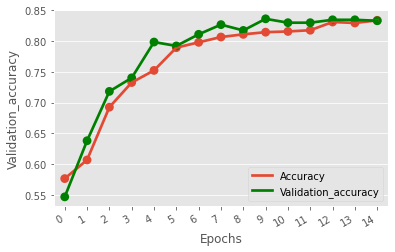

In [13]:
df = pd.DataFrame({'Epochs':history.epoch, 'Accuracy': history.history['acc'], 'Validation_accuracy': history.history['val_acc']})
ax = plt.subplot(111)
g = sns.pointplot(ax=ax, x="Epochs", y="Accuracy", data=df, fit_reg=False)
g = sns.pointplot(ax=ax, x="Epochs", y="Validation_accuracy", data=df, fit_reg=False, color='green')
ax.legend(handles=ax.lines[::len(df)+1], labels=['Accuracy', "Validation_accuracy"])
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])
plt.gcf().autofmt_xdate()
plt.show()

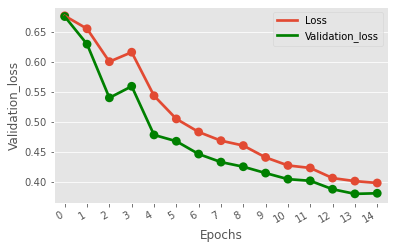

In [14]:
df = pd.DataFrame({'Epochs':history.epoch, 'Loss': history.history['loss'], 'Validation_loss': history.history['val_loss']})
ax = plt.subplot(111)
g = sns.pointplot(x="Epochs", y="Loss", data=df, fit_reg=False)
g = sns.pointplot(x="Epochs", y="Validation_loss", data=df, fit_reg=False, color='green')
ax.legend(handles=ax.lines[::len(df)+1], labels=['Loss', "Validation_loss"])
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])
plt.gcf().autofmt_xdate()
plt.show()

In [15]:
predicted = model.predict(x_test)

In [16]:
predicted

array([[1.3884413e-03, 9.9861157e-01],
       [9.9105388e-01, 8.9461105e-03],
       [8.8312107e-01, 1.1687891e-01],
       ...,
       [2.4598435e-02, 9.7540164e-01],
       [3.4729499e-04, 9.9965274e-01],
       [2.0329228e-02, 9.7967076e-01]], dtype=float32)

In [17]:
predictedmax = np.argmax(predicted, axis=1)
print("Accuracy:")
print(accuracy_score(p_test, predictedmax))

Accuracy:
0.8400503778337531


In [18]:
from sklearn.metrics import classification_report
print(classification_report(p_test, predictedmax,digits=3))

              precision    recall  f1-score   support

           0      0.844     0.755     0.797       330
           1      0.838     0.901     0.868       464

    accuracy                          0.840       794
   macro avg      0.841     0.828     0.832       794
weighted avg      0.840     0.840     0.838       794



In [19]:
from sklearn.metrics import precision_recall_fscore_support

microInfo = precision_recall_fscore_support(p_test, predictedmax, average='micro')
macroInfo = precision_recall_fscore_support(p_test, predictedmax, average='macro')
weightedInfo = precision_recall_fscore_support(p_test, predictedmax, average='weighted')

print("Micro:")
print("     precision       |      recallfloat      |   fbeta_score(F1) ")
print(str(microInfo[0])," | ",str(microInfo[1])," | ",str(microInfo[2]))
print(" ")
print("Macro:")
print("     precision       |      recallfloat      |   fbeta_score(F1) ")
print(str(macroInfo[0])," | ",str(macroInfo[1])," | ",str(macroInfo[2]))
print(" ")
print("Weighted:")
print("     precision       |      recallfloat      |   fbeta_score(F1) ")
print(str(weightedInfo[0])," | ",str(weightedInfo[1])," | ",str(weightedInfo[2]))

Micro:
     precision       |      recallfloat      |   fbeta_score(F1) 
0.8400503778337531  |  0.8400503778337531  |  0.8400503778337531
 
Macro:
     precision       |      recallfloat      |   fbeta_score(F1) 
0.8408715736557861  |  0.8277037617554859  |  0.8324602284527518
 
Weighted:
     precision       |      recallfloat      |   fbeta_score(F1) 
0.8403321607138625  |  0.8400503778337531  |  0.8384784534057351


In [20]:
for i in range(40):
    print("Feedback: " + c_test[i])
    print("SentimentPolarity: " + str(p_test[i]))
    print("SentimentScore: " + str(predictedmax[i]))
    print("Prediction:")
    for j in range(2):
        print("\tCategory " + str(j)+": " +str(predicted[i][j]))
    print("--------------------------------------")

Feedback:  activacion cada objetos es correcta durante lapso tiempo que corresponde
SentimentPolarity: 1
SentimentScore: 1
Prediction:
	Category 0: 0.0013884413
	Category 1: 0.99861157
--------------------------------------
Feedback:  no presenta un nombre diagrama distribucion objetos no estan bien definidos lo que afecta orden y ala comprension del mismo
SentimentPolarity: 0
SentimentScore: 0
Prediction:
	Category 0: 0.9910539
	Category 1: 0.0089461105
--------------------------------------
Feedback:  existen diferentes errores al momento interpretarlo estructura clase respecto atributos no comprender absoluto lo que tratando realizar
SentimentPolarity: 0
SentimentScore: 0
Prediction:
	Category 0: 0.8831211
	Category 1: 0.11687891
--------------------------------------
Feedback:  personal no medico no debe realizar tratamiento casos usos similares
SentimentPolarity: 1
SentimentScore: 0
Prediction:
	Category 0: 0.9987961
	Category 1: 0.001203855
--------------------------------------
